In [7]:
# pip install bert_score rouge_score clip sentence-transformers transformers pillow torch torchvision

from PIL import Image
import os
import clip
import torch as T
import pandas as pd

from transformers import BlipProcessor, BlipForConditionalGeneration
import pickle
import numpy as np
import glob
import regex as re

from pptx import Presentation
from io import BytesIO
import zipfile
import shutil

from bert_score import score
from rouge_score import rouge_scorer

import json
from dataset import *
import pandas as pd


device = T.device("cuda" if T.cuda.is_available() else "cpu")

## Extract Text and Images from Generated Slides

In [2]:
def extract_text_from_slide(slide):
    text = []
    for shape in slide.shapes:
        if shape.has_text_frame:
            for paragraph in shape.text_frame.paragraphs:
                text.append(paragraph.text)
    return ' '.join(text)

def extract_text(pptx_file, slide_section_counts, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    slide_sec_counts = pickle.load(open(slide_section_counts, 'rb'))
    presentation = Presentation(pptx_file)
    chapter = pptx_file.split("/")[-1][:-5]

    pptx_text_w_sections= []
    slide_no = 1
    sec = 0
    
    for slide_number, slide in enumerate(presentation.slides, start=1):
        section_slides = [] # Keeps track of slides belonging in a section
        for sec_slide in range(slide_sec_counts[sec]):
            # print(f"Processing Slide {slide_number}")
            # Extract text
            text = extract_text_from_slide(slide)
            section_slides.append(text)
            slide_no += 1
        pptx_text_w_sections.append(section_slides)
        sec += 1

    with open(os.path.join(output_folder, f"{chapter}_slide_text_info.pkl"), 'wb') as file:
        pickle.dump(pptx_text_w_sections, file)

In [12]:
chosen_chapters = ['The Goose Girl.5', 'Wuthering Heights.0', 'Frankenstein.volume 1.2']

# Extract paraphrased sentences in slide decks
for chp in chosen_chapters:
    extract_text(f'./generated_test_slides/{chp}_stablediff.pptx', f'./generated_test_slides/slide_section_counts/{chp}_sec_counts.pkl', './generated_test_slides/extracted_stablediff')
    extract_text(f'./generated_test_slides/{chp}_animatediff.pptx', f'./generated_test_slides/slide_section_counts/{chp}_sec_counts.pkl', './generated_test_slides/extracted_animatediff')

## Metric Code
- Provides code for metrics ROUGE-L and BERT
- Additionally, it has code for generating captions from resulting visuals

In [3]:
def calculate_rouge_l(reference_text, generated_text, slide_text=False, slides_per_section=0):
    # Initialize the ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=False)
    if slide_text: # Consider the number of slides dedicated to section 
        score = scorer.score(reference_text, generated_text)['rougeL'] 
        precision = score.precision * np.exp((1-slides_per_section)/1) # (actual - pred)/actual; actual is 1 as there is only one slide per section in groundtruth BookSum slide decks
        recall = score.recall * np.exp((1-slides_per_section)/1)
        f1 = score.fmeasure * np.exp((1-slides_per_section)/1)
    else:
        score = scorer.score(reference_text, generated_text)['rougeL']
        precision = score.precision
        recall = score.recall 
        f1 = score.fmeasure
    return precision, recall, f1

In [4]:
# Load BLIP model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

def image_scoring(summaries, visuals, metric):
    scores = {'precision': [], 'recall': [], 'f1': []}
    for image_path, text in zip(visuals, summaries):
        image = Image.open(image_path).convert("RGB")
        # Preprocess the image
        inputs = processor(images=image, return_tensors="pt").to(device)

        # Generate caption for the image
        outputs = model.generate(**inputs, max_new_tokens=512)
        generated_caption = processor.decode(outputs[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)

        if metric == "bert":
            precision, recall, f1 = score([text], [generated_caption], lang='en')
            scores['precision'].append(precision.item())
            scores['recall'].append(recall.item())
            scores['f1'].append(f1.item())

        elif metric == "rougel":
            precision, recall, f1 = calculate_rouge_l(text, generated_caption)
            scores['precision'].append(precision)
            scores['recall'].append(recall)
            scores['f1'].append(f1)
    
    return np.mean(scores['precision']), np.mean(scores['recall']), np.mean(scores['f1'])
        

/home/gcaraan/.conda/envs/doc2ppt-visual/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [12]:
def text_scores(chp, stories_dat, metric):
    split_name = chp.split(".")
    if len(split_name) == 2:
        book, chap = split_name
    elif len(split_name) == 3:
        book = ".".join(split_name[:-1])
        chap = split_name[-1]
    
    # ground truth slides
    sections = stories_dat[book][int(chap)]['slide']['pages']
    animate_gen_text = pickle.load(open(f'./generated_test_slides/extracted_animatediff/{chp}_animatediff_slide_text_info.pkl', 'rb'))
    stable_gen_text = pickle.load(open(f'./generated_test_slides/extracted_stablediff/{chp}_stablediff_slide_text_info.pkl', 'rb'))

    num = 1
    scores = {'precision': [], 'recall': [], 'f1': []}
    for sec, animate_slide_sec, stable_slide_sec in zip(sections, animate_gen_text, stable_gen_text):
        source_text_list = np.array([[sen['text'] for sen in slide['page']] for slide in sec]).flatten().tolist()
        source_text = " ".join(source_text_list)
        animate_text = " ".join([sen for sen in animate_slide_sec])
        stable_text = " ".join([sen for sen in animate_slide_sec])
        slides_per_section = len(animate_slide_sec) # both animatediff and stable diff should have the same number of slides per section as they've used the same Progress Tracker

        if metric == "rougel":
            animate_precision, animate_recall, animate_f1 = calculate_rouge_l(source_text, animate_text, slide_text=True, slides_per_section=slides_per_section)
            stable_precision, stable_recall, stable_f1 = calculate_rouge_l(source_text, stable_text, slide_text=True, slides_per_section=slides_per_section)

            scores['precision'].append(animate_precision)
            scores['recall'].append(animate_recall)
            scores['f1'].append(animate_f1)
            
            scores['precision'].append(stable_precision)
            scores['recall'].append(stable_recall)
            scores['f1'].append(stable_f1)
            
        elif metric == "bert":
            animate_precision, animate_recall, animate_f1 = score([source_text], [animate_text], lang='en')
            stable_precision, stable_recall, stable_f1 = score([source_text], [stable_text], lang='en')

            scores['precision'].append(animate_precision.item())
            scores['recall'].append(animate_recall.item())
            scores['f1'].append(animate_f1.item())
            
            scores['precision'].append(stable_precision.item())
            scores['recall'].append(stable_recall.item())
            scores['f1'].append(stable_f1.item())
        
        num += 1
    
    return np.mean(scores['precision']), np.mean(scores['recall']), np.mean(scores['f1'])   

## Image Relevance Scoring
- Evaluate how relevant the generated image is to the text prompt.
- Metrics used:
    - BERT Scoring
    - ROUGE-L

In [ ]:
import glob

# Test slide deck chpaters
chosen_chapters = ['The Goose Girl.5', 'Frankenstein.volume 1.2', 'Wuthering Heights.0']

slide_rougel_scores_img = {}
slide_bert_scores_img = {}
for chp in chosen_chapters:
    # Get prompts
    prompts = pickle.load(open(f'./generated_test_slides/{chp}_text_prompts.pkl', 'rb'))
    visual_prompts = [p['prompt'] if "can I help you today?" and "Join our discord for more:" not in p['prompt'] else p['context'] for p in prompts]
    
    # Get images or GIFs
    stable_image_paths = glob.glob(os.path.join(f'./generated_test_slides/{chp}_pngs/', '*.png'))
    animate_image_paths = glob.glob(os.path.join(f'./generated_test_slides/{chp}_gifs/', '*.gif'))
    
    # Get scores
    rouge_final_stable = image_scoring(visual_prompts, stable_image_paths, "rougel")
    rouge_final_animate = image_scoring(visual_prompts, animate_image_paths, "rougel")
    bert_final_stable = image_scoring(visual_prompts, stable_image_paths, "bert")
    bert_final_animate = image_scoring(visual_prompts, animate_image_paths, "bert")

    slide_rougel_scores_img[chp] = {'stablediff': rouge_final_stable, 'animatediff': rouge_final_animate}
    slide_bert_scores_img[chp] = {'stablediff': bert_final_stable, 'animatediff': bert_final_animate}

### BERT-Score Images

In [10]:
pd.DataFrame(slide_bert_scores_img['The Goose Girl.5'], index=["precision", "recall", "f1"])

,stablediff,animatediff
precision,0.811445,0.812932
recall,0.871425,0.867560
f1,0.840264,0.839336


In [11]:
pd.DataFrame(slide_bert_scores_img['Wuthering Heights.0'], index=["precision", "recall", "f1"])

,stablediff,animatediff
precision,0.811045,0.813673
recall,0.864593,0.863750
f1,0.836922,0.837882


In [13]:
pd.DataFrame(slide_bert_scores_img['Frankenstein.volume 1.2'], index=["precision", "recall", "f1"])

,stablediff,animatediff
precision,0.827049,0.829640
recall,0.865091,0.872427
f1,0.845533,0.850360


### ROUGE-L Image Scores

In [15]:
pd.DataFrame(slide_rougel_scores_img['The Goose Girl.5'], index=["precision", "recall", "f1"])

,stablediff,animatediff
precision,0.335017,0.345328
recall,0.055944,0.054334
f1,0.095324,0.093770


In [16]:
pd.DataFrame(slide_rougel_scores_img['Wuthering Heights.0'], index=["precision", "recall", "f1"])

,stablediff,animatediff
precision,0.327879,0.363205
recall,0.053287,0.057951
f1,0.091255,0.098609


In [17]:
pd.DataFrame(slide_rougel_scores_img['Frankenstein.volume 1.2'], index=["precision", "recall", "f1"])

,stablediff,animatediff
precision,0.258369,0.303571
recall,0.070807,0.068900
f1,0.108825,0.111911


## Text Quality 
- Evaluate how relevant summarised text is to raw text
- Metrics used:
    - ROUGE-SL
    - BERT Score

In [ ]:
# Load the source texts
stories_dat ={}
for conf in json.load(open('./data/v1.0/book_json.json', 'r')):
    pkl = pickle.load(open(f'./books/{conf}.pkl', 'rb'))
    stories_dat[conf] = {}
    for item in pkl:
        idd = item['idd']
        stories_dat[conf][idd] = item

# Test slide decks   
chosen_chapters = ['The Goose Girl.5', 'Wuthering Heights.0', 'Frankenstein.volume 1.2']

slide_bert_scores_text = {}
slide_rougel_scores_text = {}

for chp in chosen_chapters:
    # Compare predicted slide deck texts to ground-truth
    rouge_precision, rouge_recall, rouge_f1 = text_scores(chp, stories_dat, "rougel")
    bert_precision, bert_recall, bert_f1 = text_scores(chp, stories_dat, "bert")

    slide_rougel_scores_text[chp] = {"precision": rouge_precision, "recall": rouge_recall, "f1": rouge_f1}
    slide_bert_scores_text[chp] = {"precision": bert_precision, "recall": bert_recall, "f1": bert_f1}

### ROUGE-SL Scores

In [22]:
pd.DataFrame(slide_rougel_scores_text)

,The Goose Girl.5,Wuthering Heights.0,Frankenstein.volume 1.2
precision,0.406321,0.610684,0.343644
recall,0.229171,0.551671,0.310513
f1,0.268933,0.578241,0.324744


### BERT Score

In [21]:
pd.DataFrame(slide_bert_scores_text)

,The Goose Girl.5,Wuthering Heights.0,Frankenstein.volume 1.2
precision,0.855148,0.905362,0.870356
recall,0.865501,0.898635,0.855424
f1,0.860040,0.901974,0.862784


## Measure Layout Quality
- Evaluate the placement of images and text on the slide
- Metrics: Mean IOU
- see generating_stories jupyter notebook

## Human Evaluation Visualisation


In [8]:
# Load the CSV file
result_human = pd.read_csv("human_evaluation_results.csv").iloc[:, 1:5]
result_human

,How well does text in the slide preserve the key content of the source text?,How well does the generated image help with comprehending the source text?,"How well does the text in the slide deck flow in a logical, coherent manner, effectively telling a complete and connected story across the slides?","How well does the sequence of images in the slide deck flow in a logical, coherent manner, effectively telling a complete and connected story across the slides?"
0,3,1,3,3
1,4,5,4,5
2,5,4,4,3
3,4,5,3,5
4,4,4,4,3
5,5,3,4,4
6,2,3,3,4
7,3,4,2,3
8,2,2,3,3
9,4,3,4,3


In [62]:
# Create two dataframes for average ratings per question (means) and frequency of ratings per question (counts)
means = []
counts = []

for question in range(4):
    col = result_human.iloc[:, question]
    means.append(np.mean(col))

    df = pd.DataFrame(col.value_counts(), index=[1, 2, 3, 4, 5])
    # Replace NaN values with 0
    df.fillna(0, inplace=True)
    df.index.name = f"Question {question+1}" 

    counts.append(df)

avg_scores = pd.DataFrame(means, columns=["average_score"], index=[result_human.columns])

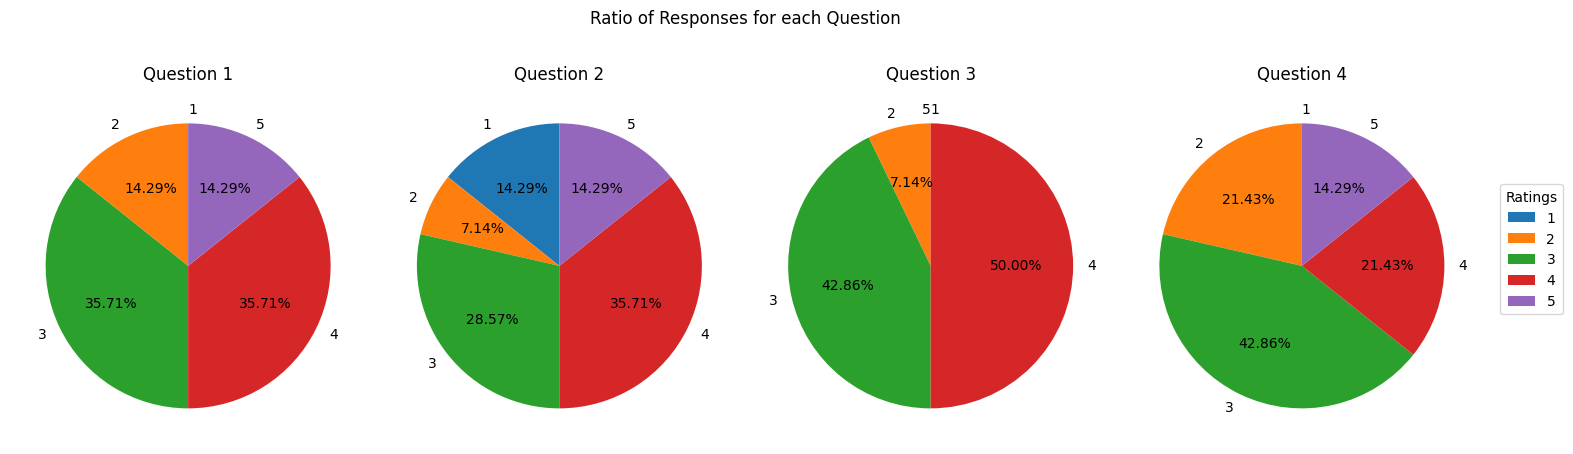

In [124]:
import matplotlib.pyplot as plt

def func(pct):
    return f'{pct:.2f}%' if pct > 0 else ''  # Show absolute value only if > 0

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes = axes.flatten()
legend_labels = []

# Plot the frequency of ratings
for ax, df in zip(axes, counts):
    df.sort_index(inplace=True)
    if len(legend_labels) == 0:
        legend_labels = df.index.tolist() 
    ax.pie(df['count'], labels = df.index , startangle = 90, autopct=lambda pct: func(pct))
    ax.set_title(df.index.name)
fig.legend(legend_labels, title="Ratings", loc="right", bbox_to_anchor=(1.05, 0.5))
fig.suptitle("Ratio of Responses for each Question")
plt.tight_layout() 
plt.show() 

(1.0, 5.0)

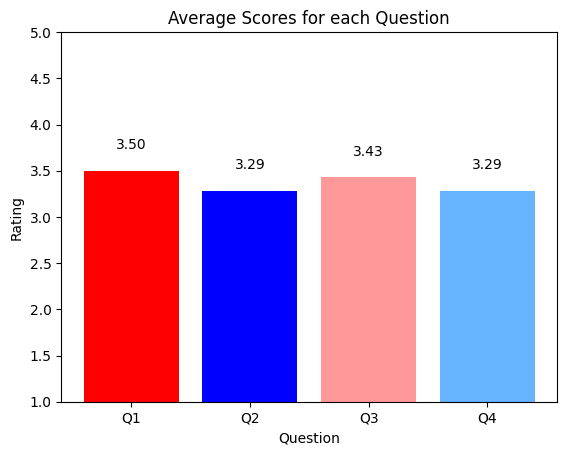

In [112]:
# Plot the averages of questions
bars = plt.bar(['Q1', 'Q2', 'Q3', 'Q4'], avg_scores['average_score'], color=['red', 'blue', '#ff9999', '#66b3ff'])
for bar in bars:
    height = bar.get_height()  # Get the height of each bar
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.2,  # Place text above the bar
             f'{height:.2f}', ha='center', va='bottom')  # Display height as text
    
plt.title("Average Scores for each Question")
plt.xlabel("Question")
plt.ylabel("Rating")
plt.ylim(1, 5)